<a href="https://colab.research.google.com/github/wallisonferreira/machine-learning-pavic/blob/main/PAVIC_ML_13_PT_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Encoders:

Compactação de imagens

## Step 1: import libs

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

torch.manual_seed(123)

## Step 2: Dataset

In [2]:
dataset_train = datasets.MNIST('MNIST_data',
                               train=True,
                               download=True,
                               transform = transforms.ToTensor()) # 28 x 28 escala de cinza

train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=256,
                                               shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 115991036.81it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41499038.65it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42559593.58it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2217498.40it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [3]:
dataset_val = datasets.MNIST('MNIST_data',
                               train=False,
                               download=True,
                               transform = transforms.ToTensor()) # 28 x 28 escala de cinza

val_dataloader = torch.utils.data.DataLoader(dataset_val,
                                               batch_size=256,
                                               shuffle=True)

## Step 3: criar o autoencoder

In [17]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(784, 32)
        self.activation0 = nn.ReLU()
        self.dense1 = nn.Linear(32, 784)
        self.activation1 = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dense0(x) # 784 -> 32 (encode)
        x = self.activation0(x)
        x = self.dense1(x) # 32 -> 784 (decode)
        x = self.activation1(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
model = autoencoder().to(device)

In [22]:
loss_fn = nn.BCELoss() # função de custo: binary crossentropy
optimizer = optim.Adam(model.parameters())

## Step 4: Treinamento do autoencoder

In [23]:
for epoch in range(20):

    running_loss_train = 0
    for data in train_dataloader:
        model.train() # seta o modelo para o modo de treinamento
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, inputs.view(*outputs.shape))
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()

    running_loss_val = 0.
    for data in val_dataloader:
        model.eval()
        with torch.inference_mode():
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
        loss = loss_fn(outputs, inputs.view(*outputs.shape))
        running_loss_val += loss.item()

    print(f"Epoch: {epoch + 1}  "
          f"train_loss: {running_loss_train/len(train_dataloader):.3f} "
          f"Val_loss: {running_loss_val/len(val_dataloader):.3f}")

Epoch: 1  train_loss: 0.288 Val_loss: 0.192
Epoch: 2  train_loss: 0.175 Val_loss: 0.158
Epoch: 3  train_loss: 0.150 Val_loss: 0.140
Epoch: 4  train_loss: 0.135 Val_loss: 0.128
Epoch: 5  train_loss: 0.126 Val_loss: 0.120
Epoch: 6  train_loss: 0.120 Val_loss: 0.115
Epoch: 7  train_loss: 0.115 Val_loss: 0.111
Epoch: 8  train_loss: 0.111 Val_loss: 0.107
Epoch: 9  train_loss: 0.108 Val_loss: 0.105
Epoch: 10  train_loss: 0.106 Val_loss: 0.104
Epoch: 11  train_loss: 0.105 Val_loss: 0.103
Epoch: 12  train_loss: 0.104 Val_loss: 0.103
Epoch: 13  train_loss: 0.104 Val_loss: 0.102
Epoch: 14  train_loss: 0.103 Val_loss: 0.102
Epoch: 15  train_loss: 0.103 Val_loss: 0.101
Epoch: 16  train_loss: 0.103 Val_loss: 0.101
Epoch: 17  train_loss: 0.103 Val_loss: 0.101
Epoch: 18  train_loss: 0.102 Val_loss: 0.101
Epoch: 19  train_loss: 0.102 Val_loss: 0.101
Epoch: 20  train_loss: 0.102 Val_loss: 0.101


## Step 5: Gerando o Encoder

In [25]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [26]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[0]
        self.activation0 = list(model.children())[1]
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dense0(x)
        x = self.activation0(x)
        return x

In [27]:
model1 = encoder().to(device)

## Step 6: Gerando o decoder

In [28]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[2]
        self.activation0 = list(model.children())[3]

    def forward(self, x):
        x = self.dense0(x)
        x = self.activation0(x)
        return x

In [29]:
model2 = decoder().to(device)

## Step 7: Visualizar os resultados

In [46]:
numero_imagens = 10
imagens_teste = next(iter(val_dataloader))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [31]:
imagens_teste.shape

torch.Size([10, 1, 28, 28])

In [47]:
# codificação das imagens de teste - model1
model1.eval()
with torch.inference_mode():
    imagens_codificadas = model1(imagens_teste)

In [39]:
imagens_codificadas.shape # codificado para 32

(10, 8, 4)

In [48]:
# decodificação das imagens
model2.eval()
with torch.inference_mode():
    imagens_decodificadas = model2(imagens_codificadas)

In [37]:
imagens_decodificadas.shape # decodificado de volta para 784

torch.Size([10, 784])

In [49]:
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 8, 4) # 8 * 4 = 32
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

### O decoder preserva as features mais fortes (espaço latente) e, por este motivo o ruído é diminuído na decodificação.

### Muito usado em sistemas de recomendação. Ele diminui a dimensionalidade das features e considera o espaço latente.

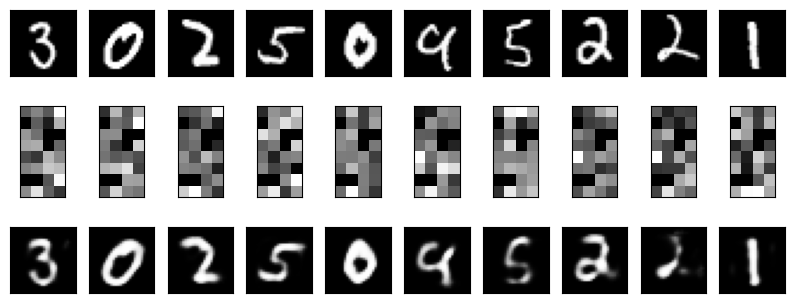

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=numero_imagens, figsize=(10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)